# Weighted K-Means

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.countries`** A 2D array with the country indicator at each latitude/longitude.


* **`utils.nx`** The number of latitudes considered.


* **`utils.ny`** The number of longitudes considered.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (100,160),
(100,170),(100,180) given as input.

## Initializing Weighted K-Means (20 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. We consider the following heuristic for initialization: We assign a random score $s(x,y)$ to each geographical coordinate $(x,y)$. The score is computed as

$$
s(x,y) = \log(1+\mathrm{population}(x,y)) + N(x,y)
$$

where $N(x,y) \sim \mathrm{exp(\lambda)}$ is a noise term that follows an exponential probability density of scale parameter $\lambda$ to be determined. The centroids are chosen to be the K locations with highest score.


**Tasks:**

* **Implement the initialization procedure above.**
* **Choose an appropriate $\lambda$ and run the initialization procedure for K=100 clusters.**
* **Visualize the centroids obtained with your initialization procedure using `utils.plot`.**

In [4]:
%matplotlib inline
import random
import numpy as np
import utils

'''We chose lambda as 0.5.
For smaller values of 1/lambda, the exponential distribution doesn't do much and the clusters cluster around big cities.
For larger values of 1/lambda, the initial distribution of the clusters becomes random '''

def initialize(k, pop):
    # the "scale"-parameter of the exponential distribution is "beta" (1/lambda) and the expected
    # value of the distribution
    r = np.log(1+utils.population) + np.random.exponential(scale=2, size=utils.population.shape)
    indx = np.argsort(r.flatten())[-k:]
    cent = np.array(zip(indx/200, indx%200))
    return cent

k = 100
r = np.log(1+utils.population) + np.random.exponential(scale=2, size=utils.population.shape)
indx = np.argsort(r.flatten())[-k:]
cent = np.array(zip(indx/200, indx%200))



## Implementing Weighted K-Means (40 P)

**Tasks:**


* **Implement the weighted K-Means algorithm as described in the introduction.**


* **Run the algorithm with K=100 centroids until convergence (stop if the objective does not improve by more than 0.01). Convergence should occur after less than 50 iterations. If it takes longer, something must be wrong.**


* **Print the value of the objective function at each iteration.**


* **Visualize the centroids at the end of the training procedure using the methods `utils.plot`.**

In [5]:
# my solution
import utils
import numpy as np
from itertools import product

def kmeans(K,population,tax_rate=0):
    """
    Param:
    K: int
        Count of centroids
    population: np.array
        Population array
    tax_rate: float
        Cost multiplier.
    """
    
    print('starting K-means. J:')
    iterCount = 50
    totalPop = np.sum(population)
    # INITIALIZATION
    centroids = initialize(K, population)

    # constructing array with all coordinates
    tmp = []
    for i in product(range(utils.nx), range(utils.ny)):
        tmp.append(i) 
    
    # Country ids at each coordinate
    countries = np.apply_along_axis(lambda x: utils.countries[tuple(x)], 1, tmp)
    
    J = 0
    for iteration in range(iterCount):

        res = []
        for k in centroids:
            if tax_rate:
                mask = np.where(countries != utils.countries[tuple(k)])
                x = np.linalg.norm(tmp - k, axis=1)**2
                x[mask] = x[mask] * tax_rate
            else: 
                x = np.linalg.norm(tmp - k, axis=1)**2
            res.append(x)

        dist = (np.array(res)).T.reshape(111,200,K)
        clusters = np.argmin(dist, axis=2)

        # calculate new centroids
        for k in range(K):
            mask = clusters == k
            indx = np.where(mask)
            centroids[k] = (population[mask] * indx).sum(axis=1) / population[mask].sum()

        # calculate objective
        oldJ = J
        J = np.sum(population * np.min(dist, axis=2)) / totalPop
        print J

        if np.abs(oldJ - J) < .01:
            print 'objective doesn\'t change anymore'
            break
        if iteration >= iterCount-1:
            print 'too many iterations'
            break

    print('done')
    return centroids

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-5-61e0a478dc8b>, line 56)

In [6]:
K = 100
centroids = kmeans(K, utils.population)        

utils.plot(centroids[:,0],centroids[:,1])

NameError: name 'kmeans' is not defined

## Focus on German-Speaking Countries (15 P)

Market analysis has shown that people in German-speaking countries, more precisely, Germany (country 111), Austria(country 104), and Switzerland (country 109), are 25 times more likely to be customers than in other countries.

**Tasks:**

* **Describe the necessary changes to the problem setup to take into account this new constraint.**

* **Run k-means on the modified problem.**

* **Visualize the newly obtained centroids using the methods `utils.plot`.**

In [ ]:
'''If German-speaking countries are 25 times more likely to be customers than in other 
countries, we think it's good to multiply the population of these countries with 25. 
This results in more clusters in the German-speaking countries.'''

starting K-means. J:
23.3203606311
10.7202780944
9.25542408891
8.68794551209
8.31996139219
8.29625456168
8.19233699152
7.96284237942
7.81958849027
7.86228466519
7.79117476231
7.86219700383
7.8788184204
7.92094293009
7.9055652796
7.81154679751
7.63569840649
7.52758819968
7.50981816446
7.48499082049
7.4389796352
7.4320233081
objective doesn't change anymore
done


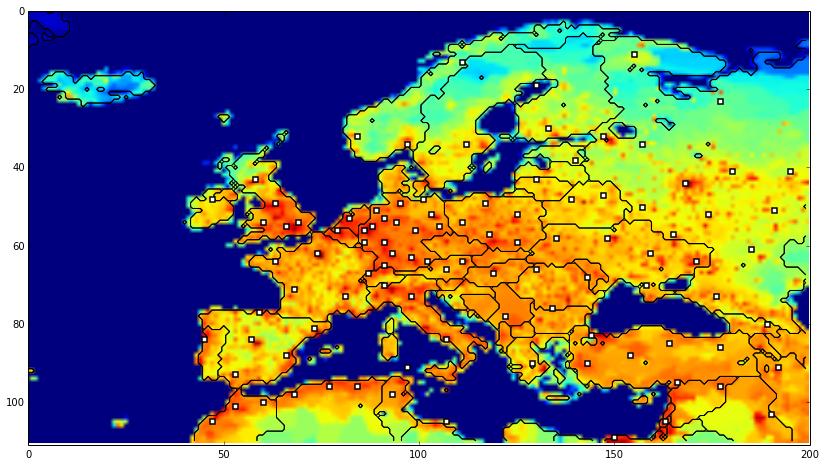

In [118]:
import utils

W = utils.population.copy()

mask = np.in1d(utils.countries, [104, 109, 111]).reshape(111,200)
W[mask] = W[mask]*25

centroids = kmeans(100,W)
utils.plot(centroids[:,0],centroids[:,1])


## Shipping Restrictions (15 P)

We now suppose that deliveries across national borders are taxed heavily, and should be avoided as much as possible.

**Tasks:**

* **Describe the necessary changes to the problem setup to take into account this new constraint.**

* **Run k-means on the modified problem.**

* **Visualize the newly obtained centroids using the methods `utils.plot`.**

In [ ]:
''' This contraint can be implemented by introducing a penalty when a point belongs to a cluster in another country.
We multiplied the distance between a point and a cluster centroid by 2.5 (arbitrary) when a border is crossed.'''

starting K-means. J:
58.9578845721
30.1109986676
27.6893075456
26.3083288738
23.6358486162
22.3173773638
22.2954751528
21.7217723163
22.1814599013
21.7393579736
21.719496382
21.6643213816
21.6209609669
21.5996967407
21.4577007147
21.4345316823
21.4108131184
21.4276569345
21.362608904
21.3484025939
21.3379844491
21.3239874732
21.3686714936
21.3484722752
21.2792594152
21.1670457177
20.9204716929
20.913496669
objective doesn't change anymore
done


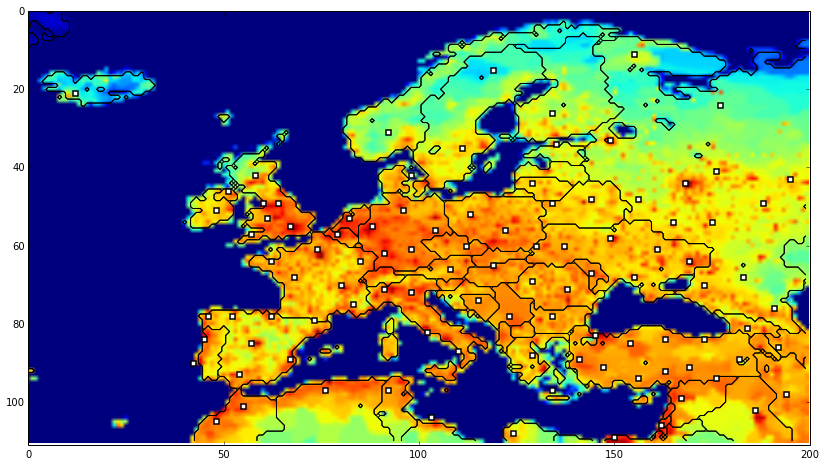

In [144]:
centroids = kmeans(100,utils.population,2.5) #tax_rate = 2.5
utils.plot(centroids[:,0],centroids[:,1])

## Discussion (10 P)

Explain in approximately two paragraphs what are the advantages and limitation of the K-Means model to the problem of optimal resource allocation. Example of points that your answer could cover are:

* Flexibility of the method with respect to various real-world constraints.
* Validity of the squared Euclidean distance as a measure of shipping cost.

In [ ]:
'''
-difficult to predict K value

-euclidean distance doesn't include sepcific costs for borders or the way has mountains/oceans
-Different initial partitions can result in different final clusters.
-It does not work well with clusters (in the original data) of Different size and Different density

'''